In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import tensorflow as tf
import math
from librosa import display
import librosa
plt.rcParams['figure.figsize'] = 15, 8
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import sklearn as sk
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import InputLayer, Input
from tensorflow.python.keras.layers import Reshape, MaxPooling2D
from tensorflow.python.keras.layers import Conv2D, Dense, Flatten
from tensorflow.keras.layers import Dropout,Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.models import load_model

import warnings
warnings.filterwarnings("ignore")
from timeit import default_timer as timer

In [2]:
with open('all_features_data.p', 'rb') as f:
    vgg_data = pickle.load(f)


In [3]:
vgg_data.head(1)

,features,label,file_name,fold,salience,class,0,1,2,3,...,886,887,888,889,890,891,892,893,894,895
0,"[157.5, 12.5, 163.5, 111.25, 182.25, 32.5, 89....",3,UrbanSound8K/audio/fold1/101415-3-0-2.wav,1,1,dog_bark,157.5,12.5,163.5,111.25,...,0.0,0.922422,-0.502428,-0.341933,0.0,1.154701,-0.99787,0.0,-0.054023,0.0


In [4]:
vgg_data.shape

(8275, 902)

In [5]:
vgg_data['label']  = vgg_data['label'].astype('int64')

## Train Test Split

In [6]:
X = list(vgg_data['features'])
X = pd.DataFrame(X)
data_cols = X.columns
y=vgg_data['label']  

In [7]:
X.shape,y.shape

((8275, 896), (8275,))

In [8]:
test_preds = {}
X_train = X[0:6692].values
X_test = X[6692:].values
y_train = y[0:6692].values
y_test = y[6692:].values

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((6692, 896), (1583, 896), (6692,), (1583,))

In [9]:
scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
## Perform Hyperparameter Optimization

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, Flatten, LeakyReLU, BatchNormalization, Dropout
from keras.activations import relu, sigmoid

Using TensorFlow backend.


In [11]:
X_train.shape[1]

896

In [12]:
def create_model(layers, activation):
    model = Sequential()
    for i, nodes in enumerate(layers):
        if i==0:
            model.add(Dense(nodes,input_dim=X_train.shape[1]))
            model.add(Activation(activation))
            model.add(Dropout(0.3))
        else:
            model.add(Dense(nodes))
            model.add(Activation(activation))
            model.add(Dropout(0.3))
            
    model.add(Dense(units = 10, activation = 'softmax')) # Note: no activation beyond this point
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    return model

In [13]:
model = KerasClassifier(build_fn=create_model, verbose=0)

layers = [(40, 20)]

activations = ['relu']

param_grid = dict(layers=layers, activation=activations, batch_size = [256], epochs=[20])


In [14]:
grid = GridSearchCV(estimator=model, param_grid=param_grid,cv=10)

In [15]:
grid_result = grid.fit(X_train, y_train)

Instructions for updating:
Colocations handled automatically by placer.


In [16]:
print(grid_result.best_score_,grid_result.best_params_)

0.7510273694992066 {'activation': 'relu', 'batch_size': 256, 'epochs': 20, 'layers': (40, 20)}


In [17]:
#Copied Results
#0.744622004032135 {'activation': 'relu', 'batch_size': 256, 'epochs': 10, 'layers': (30, 15)}
#0.759992641210556 {'activation': 'relu', 'batch_size': 256, 'epochs': 20, 'layers': (40, 20)}

In [18]:
### Build small model
def create_best_model():
    model = Sequential()
    model.add(Dense(40,input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(20, activation='relu'))
    model.add(Dropout(0.3))
    
    # Note: no activation beyond this point
    model.add(Dense(10, activation='softmax'))
    # Compile the model    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    return model


In [19]:
DNN = KerasClassifier(build_fn=create_best_model, batch_size=256, epochs=20, verbose=1)

In [20]:
best_model = DNN.fit(X_train, y_train)

Epoch 1/20
6692/6692 [==============================] - 3s 448us/step - loss: 1.9267 - accuracy: 0.3365
Epoch 2/20
6692/6692 [==============================] - 1s 124us/step - loss: 1.2876 - accuracy: 0.5613
Epoch 3/20
6692/6692 [==============================] - 1s 125us/step - loss: 1.0496 - accuracy: 0.6553
Epoch 4/20
6692/6692 [==============================] - 1s 129us/step - loss: 0.9192 - accuracy: 0.6990
Epoch 5/20
6692/6692 [==============================] - 1s 124us/step - loss: 0.8438 - accuracy: 0.7192
Epoch 6/20
6692/6692 [==============================] - 1s 149us/step - loss: 0.7538 - accuracy: 0.74900s - loss: 0.7927 
Epoch 7/20
6692/6692 [==============================] - 1s 134us/step - loss: 0.7001 - accuracy: 0.7691
Epoch 8/20
6692/6692 [==============================] - 1s 142us/step - loss: 0.6739 - accuracy: 0.7809
Epoch 9/20
6692/6692 [==============================] - 1s 104us/step - loss: 0.6325 - accuracy: 0.7890
Epoch 10/20
6692/6692 [=======================

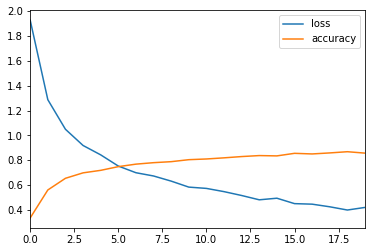

In [21]:

model_loss = pd.DataFrame(best_model.history)
model_loss.plot()

In [22]:
model_loss.sort_values(by='accuracy', ascending=False).head(5)

,loss,accuracy
18,0.399990,0.869097
17,0.425985,0.859384
19,0.420901,0.857741
15,0.451458,0.856097
16,0.447125,0.851166


In [23]:
score = best_model.model.evaluate(X_test, y_test, batch_size=256)
print(score)

1583/1583 [==============================] - 1s 728us/step
[0.7378879273174989, 0.8060644268989563]


In [24]:
predictions = best_model.model.predict_classes(X_test)

In [25]:
predictions

array([3, 0, 0, ..., 4, 4, 4], dtype=int64)

In [26]:
y_test

array([0, 0, 0, ..., 4, 4, 4], dtype=int64)

In [27]:
from sklearn.metrics import classification_report,confusion_matrix, roc_curve, auc, silhouette_samples, silhouette_score
from sklearn import metrics
print("Classification report for Keras classifier %s:\n%s\n"
      % (model, classification_report(y_test, predictions)))


Classification report for Keras classifier <keras.wrappers.scikit_learn.KerasClassifier object at 0x0000020BAFDE7AC8>:
              precision    recall  f1-score   support

           0       0.74      0.52      0.61       200
           1       0.85      0.55      0.67        40
           2       0.77      0.83      0.80       200
           3       0.77      0.79      0.78       175
           4       0.87      0.76      0.81       190
           5       0.86      0.92      0.89       182
           6       0.98      1.00      0.99        54
           7       0.77      0.97      0.86       177
           8       0.86      0.78      0.82       165
           9       0.76      0.90      0.83       200

    accuracy                           0.81      1583
   macro avg       0.82      0.80      0.81      1583
weighted avg       0.81      0.81      0.80      1583




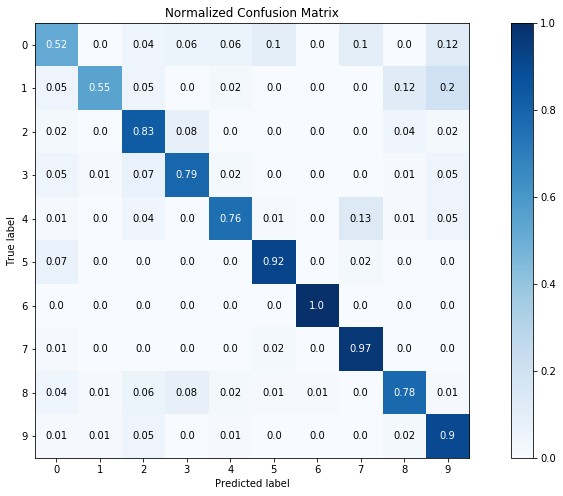

<Figure size 1080x576 with 0 Axes>

In [28]:
import scikitplot as skplt
plt.rcParams['figure.figsize'] = 15, 8
skplt.metrics.plot_confusion_matrix(y_test, predictions, normalize=True)
plt.show()
plt.savefig('DNN_GS_Confusion_Matrix.png')